In [1]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'

train_cleaned = pd.read_pickle(PATH+'train_0.pkl')
test_cleaned = pd.read_pickle(PATH+'test_0.pkl')
print('done')

done


In [2]:
print(train_cleaned.shape, test_cleaned.shape)

(307511, 1754) (48744, 1753)


In [8]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'

train_cleaned = pd.read_pickle(PATH+'train_merge.pkl')
test_cleaned = pd.read_pickle(PATH+'test_merge.pkl')
print('done')
from sklearn.preprocessing import LabelEncoder

categorical_feats = [
    'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

categorical_feats = [x for x in train_cleaned.columns if x in categorical_feats]

target = train_cleaned['TARGET']
ignore_cols = ['ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR']
features = [x for x in train_cleaned.columns if x not in ignore_cols]
train = train_cleaned[features]
test = test_cleaned[features]

for x in categorical_feats:
    if train_cleaned[x].dtype == 'object':
        print(x)
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)
        train_cleaned[x] = LabelEncoder().fit_transform(train_cleaned[x])
        test_cleaned[x] = LabelEncoder().fit_transform(test_cleaned[x])
    else:
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)
print('done')

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
done


In [4]:
print(train.shape, test.shape)

(307511, 1751) (48744, 1751)


In [ ]:
target = train_cleaned['TARGET']
ignore_cols = ['ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR']
features = [x for x in train.columns if x not in ignore_cols]
train = train[features]
test = test[features]

from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

lgbm_train = lgbm.Dataset(data=train,
                          label=target,
                          
                          categorical_feature=[],#categorical_feats,
                          free_raw_data=False)

lgbm_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 4000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1,'num_threads': 12,'feature_fraction': 0.95}

# lgbm_params = {
#     'objective': 'binary',
#     'boosting': 'gbdt',
#     'num_boost_round': 5000,
#     'learning_rate': 0.04,
#     'num_leaves': 76,
#     'num_threads': 20, # best speed: set to number of real cpu cores, which is vCPU/2
#     'device': 'cpu',
#     'max_depth': 7, # no limit. This is used to deal with over-fitting when #data is small.
#     'min_child_samples': 20,
#     'min_child_weight': 5,
#     'min_split_gain': 0,
#     'reg_alpha': 0,
#     'reg_lambda': 0.1,
#     'subsample': 1.0,
#     'subsample_for_bin': 200000,
#     'subsample_freq': 1,
#     'bagging_seed': 2018,
#     'early_stopping_round':300,
#     'verbose': 0,
#     'scale_pos_weight': 1,#*0.00246100785192494,
#     'metric' : [ 'auc'],
#     'feature_fraction': 0.8,
#     'drop_seed': 2018,
#     'data_random_seed': 2018,
#     'max_bin': 188,
#     'colsample_bytree': 0.45
# }

# lgbm_params = {
#     'boosting': 'dart',
#     'application': 'binary',
#     'learning_rate': 0.1,
#     'min_data_in_leaf': 30,
#     'num_leaves': 31,
#     'max_depth': -1,
#     'feature_fraction': 0.5,
#     'scale_pos_weight': 2,
#     'drop_rate': 0.02
# }

cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     early_stopping_rounds=150,
                     verbose_eval=100,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)

""" Predict on test set and create submission """
y_pred = clf.predict(test)
out_df = pd.DataFrame({'SK_ID_CURR': test_cleaned['SK_ID_CURR'], 'TARGET': y_pred})
print('done')

/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's auc: 0.739752 + 0.00380806
[200]	cv_agg's auc: 0.748659 + 0.0034222
[300]	cv_agg's auc: 0.759524 + 0.00341384
[400]	cv_agg's auc: 0.768842 + 0.00348434


In [12]:
print((out_df['TARGET']< 0 ).sum())
out_df.to_csv(PATH + 'inter/submod_798.csv', index=False)
print('done')

# out_df.to_csv(PATH + 'su

# out_df.to_csv(PATH + 'submission_withinstall.csv', index=False)
# print('done')

# out_df.to_csv(PATH + 'submission_withinstall.csv', index=False)
# print('done')

'''

withprev auc: 7811 pb 0.771
withinstall auc: 7815 pb 0.768
total_version_1 auc: 0.7895 pb 0.781
'''

0
done


'\n\nwithprev auc: 7811 pb 0.771\nwithinstall auc: 7815 pb 0.768\ntotal_version_1 auc: 0.7895 pb 0.781\n'

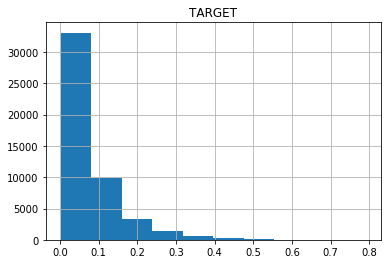

In [12]:
import matplotlib.pyplot as plt
out_df[['TARGET']].hist()
plt.show()

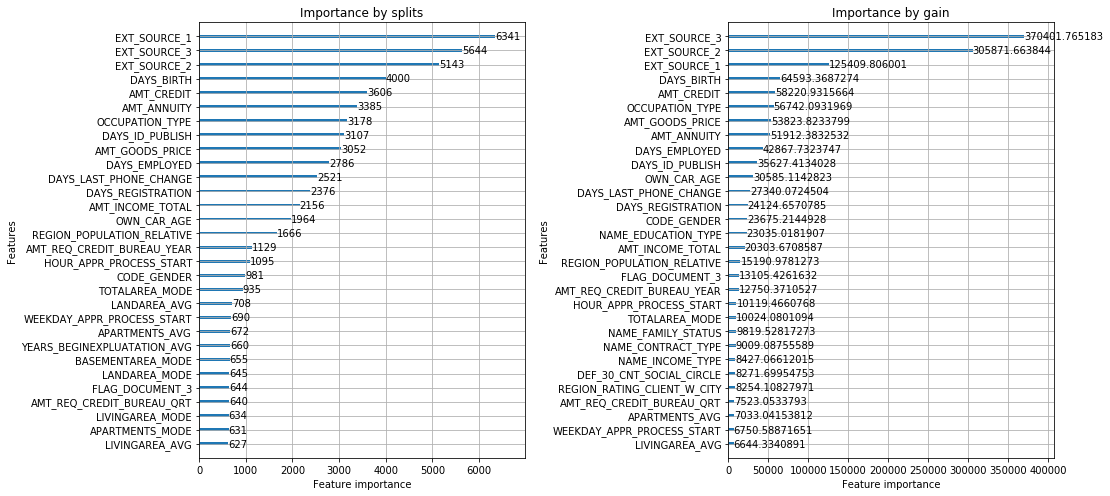

In [13]:
import matplotlib.pyplot as plt

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=30, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=30, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.show()

In [16]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('gain'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
x

[(0, ('EXT_SOURCE_3', 370401.76518294215)),
 (1, ('EXT_SOURCE_2', 305871.66384446621)),
 (2, ('EXT_SOURCE_1', 125409.80600100756)),
 (3, ('DAYS_BIRTH', 64593.368727385998)),
 (4, ('AMT_CREDIT', 58220.931566357613)),
 (5, ('OCCUPATION_TYPE', 56742.093196868896)),
 (6, ('AMT_GOODS_PRICE', 53823.823379933834)),
 (7, ('AMT_ANNUITY', 51912.383253246546)),
 (8, ('DAYS_EMPLOYED', 42867.732374660671)),
 (9, ('DAYS_ID_PUBLISH', 35627.413402825594)),
 (10, ('OWN_CAR_AGE', 30585.114282250404)),
 (11, ('DAYS_LAST_PHONE_CHANGE', 27340.072450399399)),
 (12, ('DAYS_REGISTRATION', 24124.657078504562)),
 (13, ('CODE_GENDER', 23675.214492797852)),
 (14, ('NAME_EDUCATION_TYPE', 23035.018190741539)),
 (15, ('AMT_INCOME_TOTAL', 20303.670858681202)),
 (16, ('REGION_POPULATION_RELATIVE', 15190.978127300739)),
 (17, ('FLAG_DOCUMENT_3', 13105.426163196564)),
 (18, ('AMT_REQ_CREDIT_BUREAU_YEAR', 12750.371052742004)),
 (19, ('HOUR_APPR_PROCESS_START', 10119.466076791286)),
 (20, ('TOTALAREA_MODE', 10024.08010941

In [17]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('split'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
x

[(0, ('EXT_SOURCE_1', 6341)),
 (1, ('EXT_SOURCE_3', 5644)),
 (2, ('EXT_SOURCE_2', 5143)),
 (3, ('DAYS_BIRTH', 4000)),
 (4, ('AMT_CREDIT', 3606)),
 (5, ('AMT_ANNUITY', 3385)),
 (6, ('OCCUPATION_TYPE', 3178)),
 (7, ('DAYS_ID_PUBLISH', 3107)),
 (8, ('AMT_GOODS_PRICE', 3052)),
 (9, ('DAYS_EMPLOYED', 2786)),
 (10, ('DAYS_LAST_PHONE_CHANGE', 2521)),
 (11, ('DAYS_REGISTRATION', 2376)),
 (12, ('AMT_INCOME_TOTAL', 2156)),
 (13, ('OWN_CAR_AGE', 1964)),
 (14, ('REGION_POPULATION_RELATIVE', 1666)),
 (15, ('AMT_REQ_CREDIT_BUREAU_YEAR', 1129)),
 (16, ('HOUR_APPR_PROCESS_START', 1095)),
 (17, ('CODE_GENDER', 981)),
 (18, ('TOTALAREA_MODE', 935)),
 (19, ('LANDAREA_AVG', 708)),
 (20, ('WEEKDAY_APPR_PROCESS_START', 690)),
 (21, ('APARTMENTS_AVG', 672)),
 (22, ('YEARS_BEGINEXPLUATATION_AVG', 660)),
 (23, ('BASEMENTAREA_MODE', 655)),
 (24, ('LANDAREA_MODE', 645)),
 (25, ('FLAG_DOCUMENT_3', 644)),
 (26, ('AMT_REQ_CREDIT_BUREAU_QRT', 640)),
 (27, ('LIVINGAREA_MODE', 634)),
 (28, ('APARTMENTS_MODE', 631)),
 

In [7]:
old_merge = pd.read_csv(PATH+'submission/old_merge.csv')

In [8]:
old_merge

,SK_ID_CURR,TARGET
0,100001,0.023489
1,100005,0.127016
2,100013,0.009863
3,100028,0.039796
4,100038,0.144527
5,100042,0.037338
6,100057,0.007515
7,100065,0.023357
8,100066,0.015897
9,100067,0.150622


In [28]:
len(old_merge)

48744

In [14]:
old = old_merge.copy()
old_half = old[old['TARGET'] > 0.5]

In [18]:
half_index = old_half['TARGET']

In [22]:
len(half_index)

173

In [20]:
test_half = test.iloc[half_index]

In [30]:
len(test_half)

173

In [34]:
test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,bureau_STATUS_5_std,bureau_STATUS_5_mean,bureau_STATUS_C_max,bureau_STATUS_C_min,bureau_STATUS_C_std,bureau_STATUS_C_mean,bureau_STATUS_X_max,bureau_STATUS_X_min,bureau_STATUS_X_std,bureau_STATUS_X_mean
0,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,6,...,0.0,0.0,44.0,0.0,15.614006,24.598837,9.0,0.0,3.265070,5.488372
2,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,7,...,0.0,0.0,44.0,0.0,16.856547,29.230435,40.0,0.0,15.090151,7.195652
3,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,6,...,0.0,0.0,62.0,0.0,25.617228,29.530357,60.0,0.0,20.048258,12.091071
4,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,1,1,0,270000.0,959688.0,34600.5,810000.0,6,...,0.0,0.0,64.0,0.0,27.843471,28.900813,54.0,0.0,18.638727,16.411382


In [26]:
len(test)

48743

In [29]:
half_index

37       1
202      1
538      1
634      1
998      1
1610     1
1935     1
1993     1
2035     1
2513     1
2585     1
2593     1
2764     1
2830     1
3100     1
3577     1
3640     1
4465     1
4525     1
4556     1
4567     1
4934     1
5604     1
5627     1
5719     1
5793     1
5817     1
6373     1
6678     1
6969     1
        ..
38881    1
39398    1
39553    1
39942    1
40533    1
41177    1
41338    1
41339    1
41472    1
42508    1
42746    1
42965    1
43121    1
43145    1
43171    1
43222    1
43643    1
44076    1
44283    1
45083    1
45233    1
45243    1
46145    1
46351    1
46700    1
47505    1
47611    1
47901    1
48367    1
48662    1
Name: TARGET, Length: 173, dtype: int64

In [7]:
df = pd.read_csv(PATH+'submission/modify_final.csv')

In [10]:
df.drop('Unnamed: 0', inplace = True, axis = 1)

In [11]:
df

,SK_ID_CURR,TARGET
0,100001,0.024523
1,100005,0.129060
2,100013,0.012418
3,100028,0.031481
4,100038,0.144279
5,100042,0.036397
6,100057,0.008326
7,100065,0.025811
8,100066,0.014751
9,100067,0.099353


In [15]:
df.to_csv(PATH + 'submission/mod_2.csv', index = False)

In [13]:
len(df)

48744

In [3]:
df = pd.DataFrame({'a':[1,2,3,np.nan]})
df, _ = pd.factorize(df['a'])

In [4]:
df

array([ 0,  1,  2, -1])